In [1]:
import numpy as np
import statistics as st
import pandas as pd 
import statsmodels.api as sm
from scipy import stats

In [8]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Load data from CSV files for banks and GDP
df_TCB = pd.read_csv('financial_data_TCB_filtered.csv', encoding='ISO-8859-1')
df_VCB = pd.read_csv('financial_data_VCB_filtered.csv', encoding='ISO-8859-1')
df_MBB = pd.read_csv('financial_data_MBB_filtered.csv', encoding='ISO-8859-1')
df_BID = pd.read_csv('financial_data_BID_filtered.csv', encoding='ISO-8859-1')
df_GDP = pd.read_csv('gdp_quarterly_2013_2023.csv', encoding='ISO-8859-1')

# Selected top 5 features with high correlation to "total assets"
selected_features = [
    'year', 'quarter',  'interestMargin', 'badDebtPercentage', 'loanOnEarnAsset', 'operationProfit'
]

# Helper function to filter and rename columns for each bank
def filter_and_rename(data, bank_name):
    available_features = [col for col in selected_features if col in data.columns]
    filtered_data = data[['year', 'quarter'] + available_features].copy()
    filtered_data.columns = ['year', 'quarter'] + [f"{bank_name}_{col}" for col in available_features]
    return filtered_data

# Apply the filter function to each bank's dataset
vcb_filtered = filter_and_rename(df_VCB, 'VCB')
tcb_filtered = filter_and_rename(df_TCB, 'TCB')
mbb_filtered = filter_and_rename(df_MBB, 'MBB')
bid_filtered = filter_and_rename(df_BID, 'BID')

# Prepare GDP data by extracting the year and quarter from the Date column
df_GDP['year'] = pd.to_datetime(df_GDP['Date']).dt.year
df_GDP['quarter'] = pd.to_datetime(df_GDP['Date']).dt.quarter
gdp_all_quarters = df_GDP[(df_GDP['year'] >= 2013) & (df_GDP['year'] <= 2023)]

# Merge the bank data with GDP data on 'year' and 'quarter'
merged_data = gdp_all_quarters[['year', 'quarter', 'Quarterly_GDP']].merge(vcb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(tcb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(mbb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(bid_filtered, on=['year', 'quarter'], how='left')

# Drop any rows with missing data after merging
merged_data.dropna(inplace=True)

# Define the independent variables (predictors) and the formula
independent_vars = merged_data.columns.difference(['year', 'quarter', 'Quarterly_GDP']).tolist()
formula = 'Quarterly_GDP ~ ' + ' + '.join(independent_vars)

# Fit the multivariate linear regression model using OLS (formula-based)
model = ols(formula, data=merged_data).fit()

# Display the model summary to check coefficients and p-values
print("Model Summary:")
print(model.summary())

# Check p-values to determine statistical significance
significant_features = model.pvalues[model.pvalues < 0.05].index.tolist()
print("\nSignificant features with p-value < 0.05:", significant_features)


Model Summary:
                            OLS Regression Results                            
Dep. Variable:          Quarterly_GDP   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     216.5
Date:                Sun, 17 Nov 2024   Prob (F-statistic):           5.52e-23
Time:                        15:10:27   Log-Likelihood:                -522.19
No. Observations:                  44   AIC:                             1082.
Df Residuals:                      25   BIC:                             1116.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept      

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Assuming `merged_data` is prepared as per your earlier script
# Load data from CSV files for banks and GDP
df_TCB = pd.read_csv('financial_data_TCB_filtered.csv', encoding='ISO-8859-1')
df_VCB = pd.read_csv('financial_data_VCB_filtered.csv', encoding='ISO-8859-1')
df_MBB = pd.read_csv('financial_data_MBB_filtered.csv', encoding='ISO-8859-1')
df_BID = pd.read_csv('financial_data_BID_filtered.csv', encoding='ISO-8859-1')
df_GDP = pd.read_csv('gdp_quarterly_2013_2023.csv', encoding='ISO-8859-1')

# Selected top 5 features with high correlation to "total assets"
selected_features = [
    'interestMargin', 'badDebtPercentage', 'loanOnEarnAsset', 'operationProfit'
]

# Helper function to filter and rename columns for each bank
def filter_and_rename(data, bank_name):
    available_features = [col for col in selected_features if col in data.columns]
    filtered_data = data[['year', 'quarter'] + available_features].copy()
    filtered_data.columns = ['year', 'quarter'] + [f"{bank_name}_{col}" for col in available_features]
    return filtered_data

# Apply the filter function to each bank's dataset
vcb_filtered = filter_and_rename(df_VCB, 'VCB')
tcb_filtered = filter_and_rename(df_TCB, 'TCB')
mbb_filtered = filter_and_rename(df_MBB, 'MBB')
bid_filtered = filter_and_rename(df_BID, 'BID')

# Prepare GDP data by extracting the year and quarter from the Date column
df_GDP['year'] = pd.to_datetime(df_GDP['Date']).dt.year
df_GDP['quarter'] = pd.to_datetime(df_GDP['Date']).dt.quarter
gdp_all_quarters = df_GDP[(df_GDP['year'] >= 2013) & (df_GDP['year'] <= 2023)]

# Merge the bank data with GDP data on 'year' and 'quarter'
merged_data = gdp_all_quarters[['year', 'quarter', 'Quarterly_GDP']].merge(vcb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(tcb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(mbb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(bid_filtered, on=['year', 'quarter'], how='left')

# Drop any rows with missing data after merging
merged_data.dropna(inplace=True)
# Apply log transformation where appropriate
for var in merged_data.columns.difference(['Quarterly_GDP']):
    if (merged_data[var] > 0).all():
        merged_data[f"log_{var}"] = np.log(merged_data[var])

# Add interaction terms
merged_data['interaction_loan_margin'] = (
    merged_data.get('log_MBB_loanOnEarnAsset', merged_data['MBB_loanOnEarnAsset']) *
    merged_data.get('log_TCB_interestMargin', merged_data['TCB_interestMargin'])
)

# Define the independent variables (log-transformed and interaction terms included)
independent_vars = merged_data.columns.difference(['Quarterly_GDP', 'year', 'quarter']).tolist()

# Define the formula for regression
formula = 'Quarterly_GDP ~ ' + ' + '.join(independent_vars)

# Fit the OLS model
model = ols(formula, data=merged_data).fit()

# Generate and display the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print("ANOVA Table:")
print(anova_table)

# Display the refined model summary
print("\nRefined Model Summary:")
print(model.summary())


ANOVA Table:
                                 sum_sq   df          F    PR(>F)
BID_badDebtPercentage      5.237151e+06  1.0   0.006804  0.936286
BID_interestMargin         2.466290e+08  1.0   0.320424  0.586876
BID_loanOnEarnAsset        9.602514e+05  1.0   0.001248  0.972689
BID_operationProfit        5.165123e+08  1.0   0.671061  0.436404
MBB_badDebtPercentage      7.069944e+07  1.0   0.091854  0.769565
MBB_interestMargin         1.675987e+07  1.0   0.021775  0.886339
MBB_loanOnEarnAsset        2.699345e+07  1.0   0.035070  0.856111
MBB_operationProfit        2.024478e+09  1.0   2.630232  0.143504
TCB_badDebtPercentage      5.489020e+08  1.0   0.713142  0.422936
TCB_interestMargin         9.679380e+08  1.0   1.257560  0.294643
TCB_loanOnEarnAsset        5.757773e+07  1.0   0.074806  0.791392
TCB_operationProfit        2.296573e+09  1.0   2.983742  0.122373
VCB_badDebtPercentage      1.534514e+09  1.0   1.993664  0.195652
VCB_interestMargin         2.806300e+08  1.0   0.364599  0.5626

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import statsmodels.api as sm
import numpy as np

# Load data from CSV files for banks and GDP
df_TCB = pd.read_csv('financial_data_TCB_filtered.csv', encoding='ISO-8859-1')
df_VCB = pd.read_csv('financial_data_VCB_filtered.csv', encoding='ISO-8859-1')
df_MBB = pd.read_csv('financial_data_MBB_filtered.csv', encoding='ISO-8859-1')
df_BID = pd.read_csv('financial_data_BID_filtered.csv', encoding='ISO-8859-1')
df_GDP = pd.read_csv('gdp_quarterly_2013_2023.csv', encoding='ISO-8859-1')

# Selected top 5 features with high correlation to "total assets"
selected_features = [
    'year', 'quarter',  'interestMargin', 'badDebtPercentage', 'loanOnEarnAsset','operationProfit'
]

# Helper function to filter and rename columns for each bank
def filter_and_rename(data, bank_name):
    available_features = [col for col in selected_features if col in data.columns]
    filtered_data = data[['year', 'quarter'] + available_features].copy()
    filtered_data.columns = ['year', 'quarter'] + [f"{bank_name}_{col}" for col in available_features]
    return filtered_data

# Apply the filter function to each bank's dataset
vcb_filtered = filter_and_rename(df_VCB, 'VCB')
tcb_filtered = filter_and_rename(df_TCB, 'TCB')
mbb_filtered = filter_and_rename(df_MBB, 'MBB')
bid_filtered = filter_and_rename(df_BID, 'BID')

# Prepare GDP data by extracting the year and quarter from the Date column
df_GDP['year'] = pd.to_datetime(df_GDP['Date']).dt.year
df_GDP['quarter'] = pd.to_datetime(df_GDP['Date']).dt.quarter
gdp_all_quarters = df_GDP[(df_GDP['year'] >= 2013) & (df_GDP['year'] <= 2023)]

# Merge the bank data with GDP data on 'year' and 'quarter'
merged_data = gdp_all_quarters[['year', 'quarter', 'Quarterly_GDP']].merge(vcb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(tcb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(mbb_filtered, on=['year', 'quarter'], how='left') \
                                                                  .merge(bid_filtered, on=['year', 'quarter'], how='left')

# Drop any rows with missing data after merging
merged_data.dropna(inplace=True)

# Define X and y
X = merged_data.drop(columns=['year', 'quarter', 'Quarterly_GDP'])  # Independent variables
y = merged_data['Quarterly_GDP']  # Dependent variable: GDP

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model on the training set
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred_test = model.predict(X_test)

# Calculate RMSE on the test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print("RMSE on test set:", rmse_test)

# Calculate MAPE on the test set
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
print("MAPE on test set:", mape_test)


RMSE on test set: 88917.90712252987
MAPE on test set: 0.04594983779177218


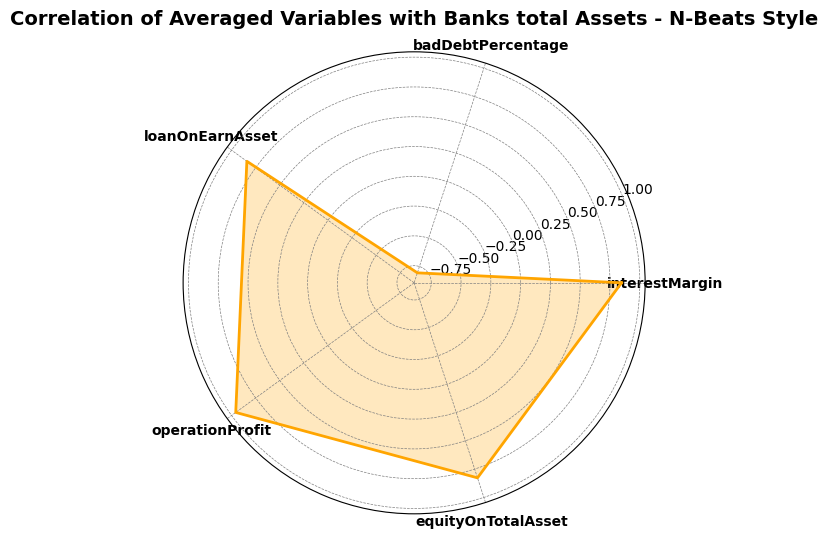

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Load data for banks and GDP
df_TCB = pd.read_csv('financial_data_TCB_filtered.csv', encoding='ISO-8859-1')
df_VCB = pd.read_csv('financial_data_VCB_filtered.csv', encoding='ISO-8859-1')
df_MBB = pd.read_csv('financial_data_MBB_filtered.csv', encoding='ISO-8859-1')
df_BID = pd.read_csv('financial_data_BID_filtered.csv', encoding='ISO-8859-1')
df_GDP = pd.read_csv('gdp_quarterly_2013_2023.csv', encoding='ISO-8859-1')

# Convert Date column in GDP data to datetime
df_GDP['Date'] = pd.to_datetime(df_GDP['Date'])
df_GDP['year'] = df_GDP['Date'].dt.year
df_GDP['quarter'] = df_GDP['Date'].dt.quarter

# Define selected features with high relevance to GDP
selected_features = [ 'interestMargin', 'badDebtPercentage', 'loanOnEarnAsset', 'operationProfit','equityOnTotalAsset']

# Helper function to filter and rename columns for each bank
def filter_and_rename(data, bank_name):
    available_features = [col for col in selected_features if col in data.columns]
    filtered_data = data[['year', 'quarter'] + available_features].copy()
    filtered_data.columns = ['year', 'quarter'] + [f"{bank_name}_{col}" for col in available_features]
    return filtered_data

# Apply the filter function to each bank's dataset
vcb_filtered = filter_and_rename(df_VCB, 'VCB')
tcb_filtered = filter_and_rename(df_TCB, 'TCB')
mbb_filtered = filter_and_rename(df_MBB, 'MBB')
bid_filtered = filter_and_rename(df_BID, 'BID')

# Merge the bank data with GDP data on 'year' and 'quarter'
gdp_all_quarters = df_GDP[['year', 'quarter', 'Quarterly_GDP']]
merged_data = gdp_all_quarters.merge(vcb_filtered, on=['year', 'quarter'], how='left') \
                              .merge(tcb_filtered, on=['year', 'quarter'], how='left') \
                              .merge(mbb_filtered, on=['year', 'quarter'], how='left') \
                              .merge(bid_filtered, on=['year', 'quarter'], how='left')

# Drop any rows with missing data after merging
merged_data.dropna(inplace=True)

# Average each metric across the four banks
for feature in selected_features:
    merged_data[feature] = merged_data[[f"VCB_{feature}", f"TCB_{feature}", f"MBB_{feature}", f"BID_{feature}"]].mean(axis=1)

# Calculate correlation with GDP using the averaged metrics
correlation_with_gdp = merged_data[selected_features].corrwith(merged_data['Quarterly_GDP'])

# Prepare data for radar chart
labels = correlation_with_gdp.index
values = correlation_with_gdp.values
num_vars = len(labels)

# Compute angle for each axis on the radar chart
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]  # Complete the loop for a full radar chart

# Repeat the first value to close the radar chart loop
values = np.concatenate((values, [values[0]]))

# Plot radar chart
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, values, color='orange', linewidth=2, linestyle='solid')
ax.fill(angles, values, color='orange', alpha=0.25)

# Add labels to each axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10, fontweight='bold')

# Title and grid settings
plt.title("Correlation of Averaged Variables with Banks total Assets - N-Beats Style", size=14, fontweight='bold', pad=20)
ax.grid(color='gray', linestyle='--', linewidth=0.5)

# Show plot
plt.show()


| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=True)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @2221400291136
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @2221400291136
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @2221400291136
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @2221400291136
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @2221400291136
| --  Stack Generic (#1) (share_weights_in_stack=True)
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @2221203214400
     | -- GenericBlock(units=128, thetas_dim=4, backcast_length=8, forecast_length=1, share_thetas=False) at @2221203214400
     | -- Ge

11:14:22 - cmdstanpy - INFO - Chain [1] start processing
11:14:23 - cmdstanpy - INFO - Chain [1] done processing


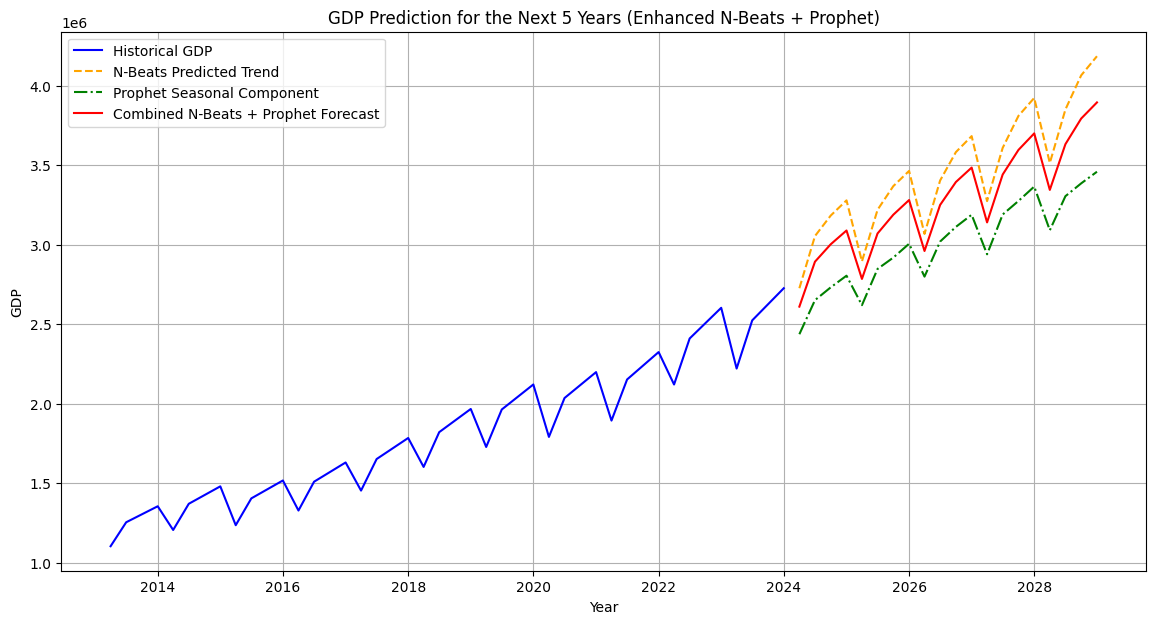

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from nbeats_pytorch.model import NBeatsNet
import torch
from sklearn.preprocessing import MinMaxScaler

# Load data for banks and GDP
df_TCB = pd.read_csv('financial_data_TCB_filtered.csv', encoding='ISO-8859-1')
df_VCB = pd.read_csv('financial_data_VCB_filtered.csv', encoding='ISO-8859-1')
df_MBB = pd.read_csv('financial_data_MBB_filtered.csv', encoding='ISO-8859-1')
df_BID = pd.read_csv('financial_data_BID_filtered.csv', encoding='ISO-8859-1')
df_GDP = pd.read_csv('gdp_quarterly_2013_2023.csv', encoding='ISO-8859-1')

# Convert Date column in GDP data to datetime
df_GDP['Date'] = pd.to_datetime(df_GDP['Date'])

# Define selected features with high relevance to GDP based on OLS analysis
selected_features = [
     'year', 'quarter',  'interestMargin', 'badDebtPercentage', 'loanOnEarnAsset', 'operationProfit'
]

# Helper function to filter and rename columns for each bank
def filter_and_rename(data, bank_name):
    available_features = [col for col in selected_features if col in data.columns]
    filtered_data = data[['year', 'quarter'] + available_features].copy()
    filtered_data.columns = ['year', 'quarter'] + [f"{bank_name}_{col}" for col in available_features]
    return filtered_data

# Apply the filter function to each bank's dataset
vcb_filtered = filter_and_rename(df_VCB, 'VCB')
tcb_filtered = filter_and_rename(df_TCB, 'TCB')
mbb_filtered = filter_and_rename(df_MBB, 'MBB')
bid_filtered = filter_and_rename(df_BID, 'BID')

# Prepare GDP data by extracting the year and quarter from the Date column
df_GDP['year'] = df_GDP['Date'].dt.year
df_GDP['quarter'] = df_GDP['Date'].dt.quarter
gdp_all_quarters = df_GDP[['year', 'quarter', 'Quarterly_GDP']]

# Merge the bank data with GDP data on 'year' and 'quarter'
merged_data = gdp_all_quarters.merge(vcb_filtered, on=['year', 'quarter'], how='left') \
                              .merge(tcb_filtered, on=['year', 'quarter'], how='left') \
                              .merge(mbb_filtered, on=['year', 'quarter'], how='left') \
                              .merge(bid_filtered, on=['year', 'quarter'], how='left')

# Drop any rows with missing data after merging
merged_data.dropna(inplace=True)

# Select the high-correlation features for N-Beats
X = merged_data.drop(columns=['year', 'quarter', 'Quarterly_GDP'])
y = merged_data['Quarterly_GDP']

# Normalize the GDP values for N-Beats
scaler = MinMaxScaler()
gdp_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

# Prepare training data for N-Beats (using last 8 quarters for prediction)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 8  # Eight quarters sequence
X_seq, y_seq = create_sequences(gdp_scaled, seq_length)

# Convert data to PyTorch tensors
X_torch = torch.tensor(X_seq, dtype=torch.float32)
y_torch = torch.tensor(y_seq, dtype=torch.float32)

# Define the N-Beats model without dropout
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NBeatsNet(
    backcast_length=seq_length,
    forecast_length=1,
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    nb_blocks_per_stack=5,  # More blocks per stack
    thetas_dim=(4, 4),
    share_weights_in_stack=True,
    hidden_layer_units=128  # Increased hidden units
).to(device)

# Loss function and optimizer with weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_fn = torch.nn.MSELoss()

# Train N-Beats model with additional epochs
epochs = 700  # Increased epochs for better training
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    backcast, forecast = model(X_torch.to(device))
    forecast = forecast.squeeze()
    loss = loss_fn(forecast.view(-1, 1), y_torch.to(device))
    loss.backward()
    optimizer.step()

# Forecast next 20 quarters (5 years) with N-Beats
model.eval()
backcast = torch.tensor(gdp_scaled[-seq_length:], dtype=torch.float32).unsqueeze(0).to(device)
nbeats_forecast = []

with torch.no_grad():
    for _ in range(20):  # Predicting for the next 5 years (20 quarters)
        _, forecast = model(backcast)
        forecast_value = forecast.item()
        nbeats_forecast.append(forecast_value)
        # Update the backcast with the forecast for next prediction
        backcast = torch.cat([backcast[:, 1:], forecast.unsqueeze(0)], dim=1)

# Inverse scale N-Beats predictions
nbeats_forecast = scaler.inverse_transform(np.array(nbeats_forecast).reshape(-1, 1))

# Calibrate N-Beats prediction to match the last known GDP value
last_known_gdp = merged_data['Quarterly_GDP'].iloc[-1]
nbeats_forecast = nbeats_forecast.flatten() - nbeats_forecast[0] + last_known_gdp

# Prepare data for Prophet with adjusted Fourier order
prophet_data = df_GDP[['Date', 'Quarterly_GDP']].rename(columns={'Date': 'ds', 'Quarterly_GDP': 'y'})
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.add_seasonality(name='quarterly', period=3, fourier_order=10)  # Increased Fourier order
prophet_model.fit(prophet_data)

# Forecast seasonality with Prophet
future = prophet_model.make_future_dataframe(periods=20, freq='QE')
prophet_forecast = prophet_model.predict(future)
prophet_forecast = prophet_forecast[['ds', 'yhat']].tail(20)  # Only future dates

# Combine N-Beats and Prophet into a single DataFrame
combined_forecast = pd.DataFrame({
    'Date': pd.to_datetime(prophet_forecast['ds']),
    'NBeats_Predicted_GDP': nbeats_forecast,
    'Prophet_Seasonal_GDP': prophet_forecast['yhat'].values
})

# Weighted combination of N-Beats and Prophet outputs
combined_forecast['Final_Predicted_GDP'] = (
    0.6 * combined_forecast['NBeats_Predicted_GDP'] +
    0.4 * combined_forecast['Prophet_Seasonal_GDP']
)

# Plot the results: N-Beats, Prophet, and Combined Forecast
plt.figure(figsize=(14, 7))
# Historical GDP data
plt.plot(df_GDP['Date'], df_GDP['Quarterly_GDP'], label='Historical GDP', color='blue')
# N-Beats trend forecast
plt.plot(combined_forecast['Date'], combined_forecast['NBeats_Predicted_GDP'], label='N-Beats Predicted Trend', color='orange', linestyle='--')
# Prophet seasonality forecast
plt.plot(combined_forecast['Date'], combined_forecast['Prophet_Seasonal_GDP'], label='Prophet Seasonal Component', color='green', linestyle='-.')
# Combined forecast
plt.plot(combined_forecast['Date'], combined_forecast['Final_Predicted_GDP'], label='Combined N-Beats + Prophet Forecast', color='red', linestyle='-')

plt.xlabel('Year')
plt.ylabel('GDP')
plt.title('GDP Prediction for the Next 5 Years (Enhanced N-Beats + Prophet)')
plt.legend()
plt.grid(True)
plt.show()
